In [160]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['track_popularity', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'tempo', 'duration_ms']
True
/knowledge
addtemporal

0  acousticness duration_ms instrumentalness key loudness speechiness tempo
1  track_popularity

forbiddirect

requiredirect
[loudness --- instrumentalness, duration_ms --- instrumentalness, loudness --- duration_ms]
nodes = ['track_popularity', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'tempo', 'duration_ms']
edges = [('acousticness', 'tempo'), ('acousticness', 'track_popularity'), ('duration_ms', 'acousticness'), ('duration_ms', 'instrumentalness'), ('duration_ms', 'speechiness'), ('duration_ms', 'track_popularity'), ('instrumentalness', 'acousticness'), ('instrumentalness', 'speechiness'), ('instrumentalness', 'tempo'), ('instrumentalness', 'track_popularity'), ('key', 'speechiness'), ('key', 'tempo'), ('loudness', 'acousticness'), ('loudness', 'duration_ms'), ('loudness', 'instrumentalness'), ('loudness', 'speech

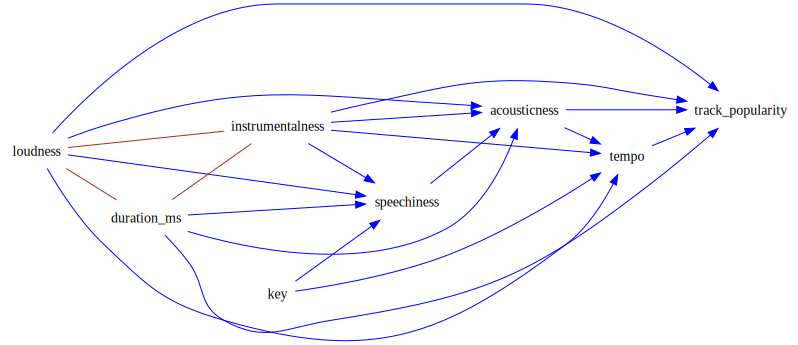

In [165]:
from discovery import run_pc, draw

nodes, edges = run_pc("spotify_binary.csv", knowledge="spotify_knowledge.txt")

print("nodes =", nodes)
print("edges =", [(x[0], x[2]) for x in edges])


draw(nodes, edges)



In [206]:
from causal import CausalDAG, augmented_ipw, compute_confidence_intervals

import pandas as pd

df = pd.read_csv('binary_small_noise.csv')

nodes = ['V8', 'V2', 'V4', 'Y', 'V6', 'V3', 'V5', 'V7', 'V9', 'V1']
edges = [#('Y', 'V5'),
    ('V2', 'V8'), ('V2', 'V4'), ('Y', 'V8'), ('V4', 'Y'), ('V2', 'V3'), ('V3', 'Y'), ('V2', 'V5'), ('V3', 'V5'), ('Y', 'V7'), ('V8', 'V9'), ('V7', 'V9'), ('V6', 'Y'), ('V1', 'V3'), ('V1', 'Y'), ('V3', 'V4')]


#TODO mess with graph

dag = CausalDAG(nodes, edges)

treatment_nodes = ['V8', 'V2', 'V4', 'V6', 'V3', 'V5', 'V7', 'V9', 'V1']
# treatment_nodes = ['V9']

for i in treatment_nodes:
    
    out = dag.find_minimal_optimal_backdoor(i, "Y")
    if out is None:
        print(i, "Y", "[No Causal Relationship]")
        continue
    treatment, outcome, adj_set = out
    print(treatment, outcome, adj_set)
    print(dag.valid_backdoor_set(treatment, outcome, adj_set))
    
    print(augmented_ipw(df, treatment, outcome, adj_set), compute_confidence_intervals(df, treatment, outcome, adj_set, augmented_ipw))

    


# print(squash_paths(dag.find_causal_paths("V9", "Y")))
dag.draw()

Y V8 ['V2']
True
0.236 (0.187, 0.277)
V2 Y []
True
0.104 (0.05, 0.165)
V4 Y ['V3', 'V1']
True


KeyboardInterrupt: 

V6 Y ['Y', 'V4', 'V7', 'V2', 'V3', 'V1']
False
inst None
set() {'V6'} True True
here
med ('V7', set())


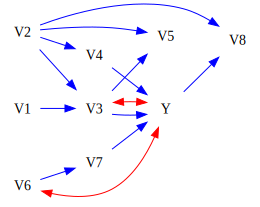

In [222]:
from causal_admg import CausalADMG

nodes = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'Y', 'V7', 'V8']
di_edges = [('V1', 'V3'), ('V2', 'V3'), ('V2', 'V4'), ('V2', 'V5'), ('V3', 'Y'), ('V6', 'V7'), ('V7', 'Y'), ('V3', 'V5'), ('V4', 'Y'), ('V2', 'V8'), ('Y', 'V8')]
bi_edges = [('V3', 'Y'), ('V6', 'Y')]

G = CausalADMG(nodes, di_edges, bi_edges)

# treatment_nodes = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8']
treatment_nodes = ['V6']

for i in treatment_nodes:
    
    out = G.find_minimal_adjustment_set(i, "Y")
    if out is None:
        print(i, "Y", "[No Causal Relationship]")
        continue
    treatment, outcome, adj_set = out
    print(treatment, outcome, adj_set)
    print(G.valid_backdoor_set(treatment, outcome, adj_set))
    if not G.valid_backdoor_set(treatment, outcome, adj_set):
        frontdoor = G.find_mediator(treatment, outcome)
        if frontdoor is None:
            instrument =  G.find_instrument(treatment, outcome)
    
    
    # print(augmented_ipw(df, treatment, outcome, adj_set), compute_confidence_intervals(df, treatment, outcome, adj_set, augmented_ipw))

    
G.draw()
